# Processing of the Data Science Bowl 2018 kaggle dataset with u-net neural network

In [1]:
%matplotlib inline 
import matplotlib
import keras
import sys
import os
from glob import glob
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("data")
from data.data_helper import show_data_from_generator
from models.unet import *
from data.dsb import DataScienceBowl2018
from data.dataset import Dataset
from callbacks import ImageHistory

Using TensorFlow backend.


## Directories

In [2]:
# location where the dataset will be downloaded
dataset_location = './data/datasets/data-science-bowl-2018'
tensor_board_directory = './logs'
weight_file = './unet_dsb_weights.hdf5'

## Parameters

In [3]:
learning_rate = 1e-4
input_shape=(256,256,1)
loss = 'binary_crossentropy'
steps_per_epoch = 4000
epochs = 3
batch_size = 20
start_epoch = 2
last_step = 84
clear_all = False
prepare_dataset = False

## Clear data from previous executions if needed

In [4]:
if clear_all:
    if os.path.exists(weight_file):
        os.remove(weight_file)
    files = glob(tensor_board_directory +'/*')
    for f in files:
        os.remove(f)

## Setup dataset
The dataset contains tissue scans and binary masks for identification of nuclei. Each mask contains shape of a single nucleus.
The dataset is available through WEB site https://www.kaggle.com/c/data-science-bowl-2018. Dataset class uses kaggle API for 
downloading of the data. It requires a kaggle account. See https://github.com/Kaggle/kaggle-api for details.

This section performs following operations:
- downloading of the dataset;
- combination of a slide masks in a single mask with outlines of all slide nuclei;
- invert bright slides;
- defines the training, validation and test datasets by clustering of images according to the image raster statistics and making sure that each set contains equal amount of images from the clusters; 
- splits slides to tiles 256x256. The tiles normally overlap with each other;

For the more detailed information see notebook ./data/data-science-bowl.ipynb.

In [5]:
dataset = DataScienceBowl2018(dataset_location)

In [6]:
if prepare_dataset:
    dataset.clear()
    dataset.download()
    dataset.prepare()

### Show original images (not preprocessed)
This section shows several original slides and corresponded nucleus masks. The masks are already combined together. One row shows images, anoter corresponded masks.

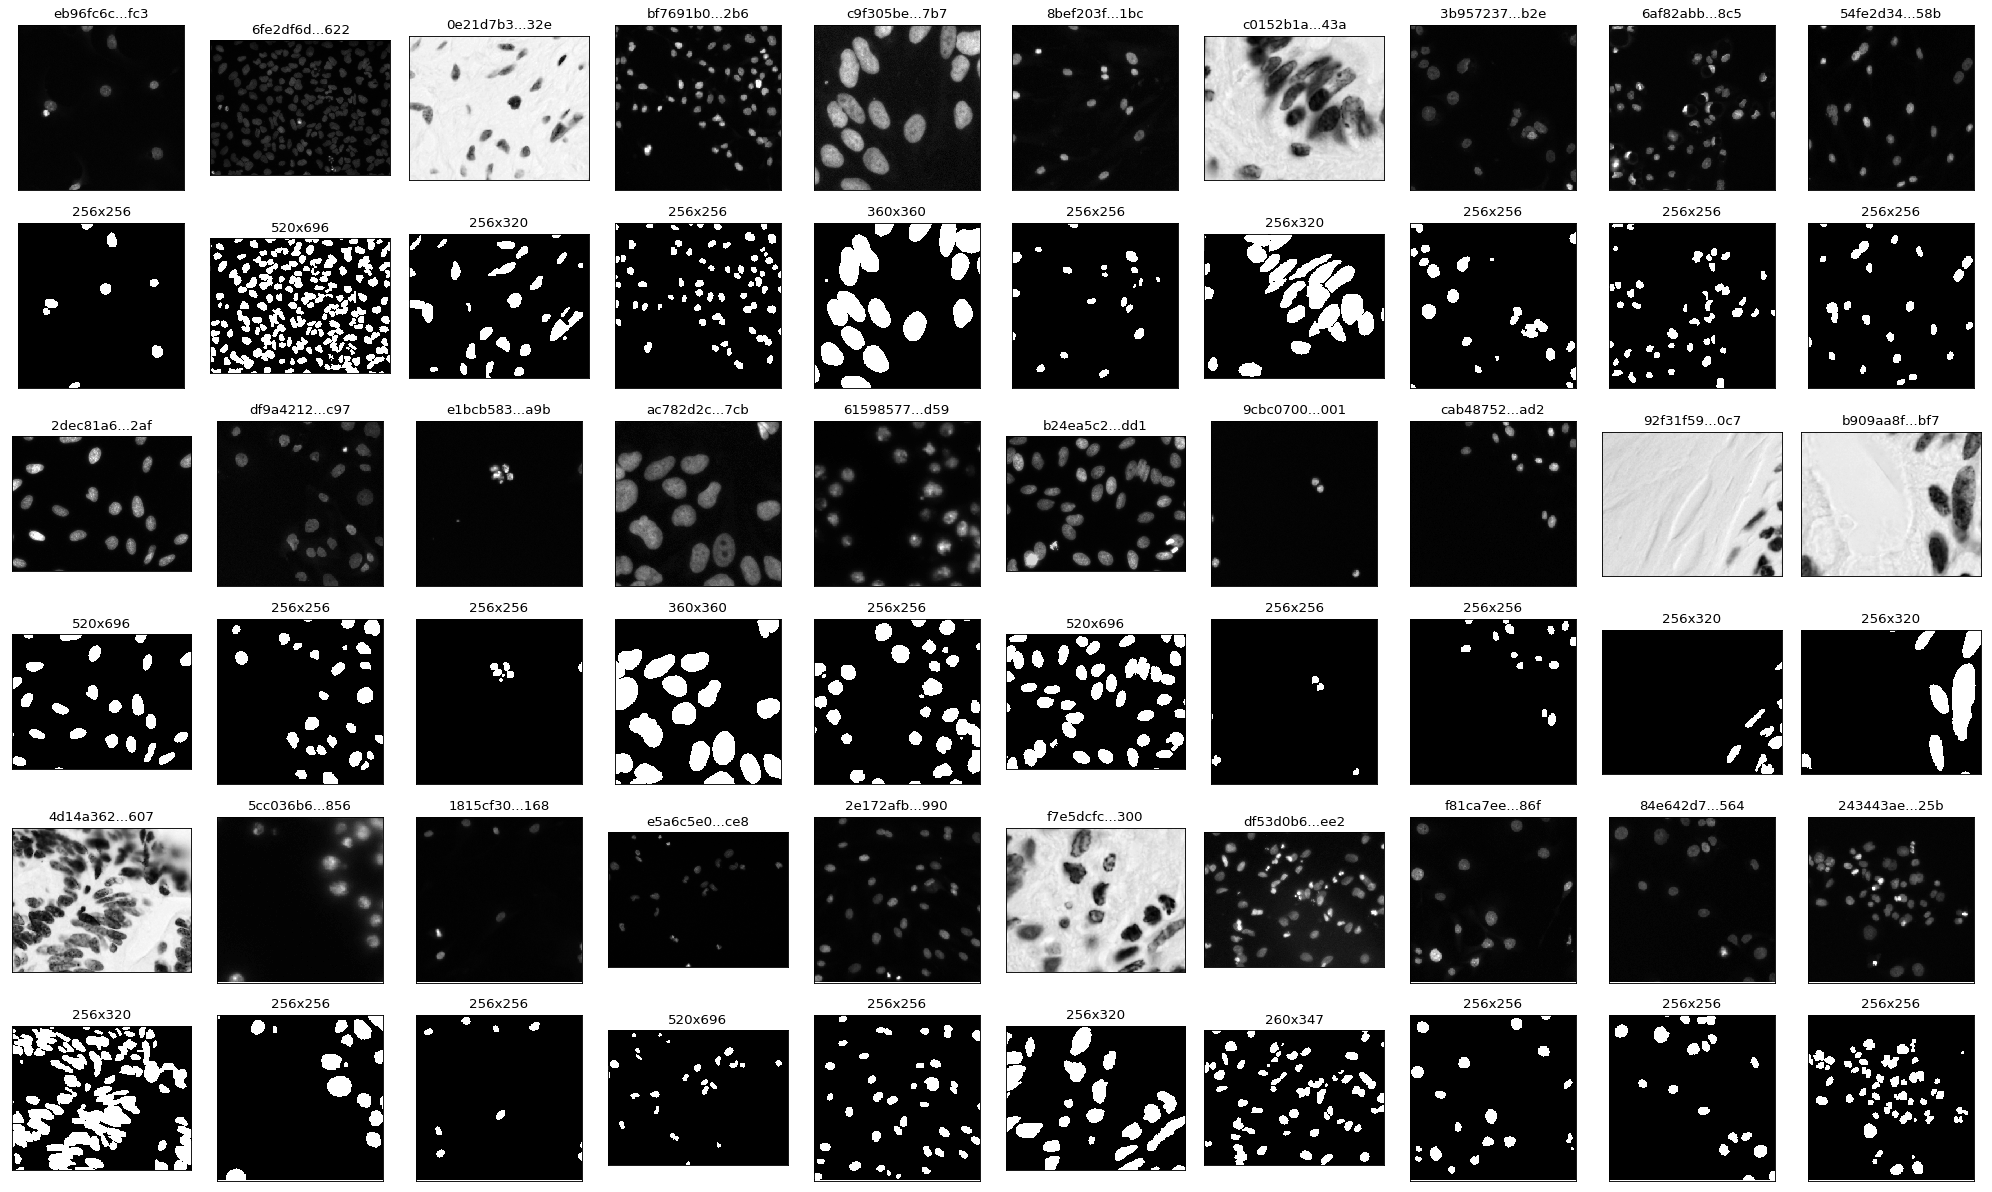

In [7]:
generator = dataset.source_generator()
show_data_from_generator(generator,3, 10, (25,15))

### Show some preprocessed training images
This section shows 256x256 tiles created from the original images together with corresponded masks

Found 1962 images belonging to 1 classes.
Found 1962 images belonging to 1 classes.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


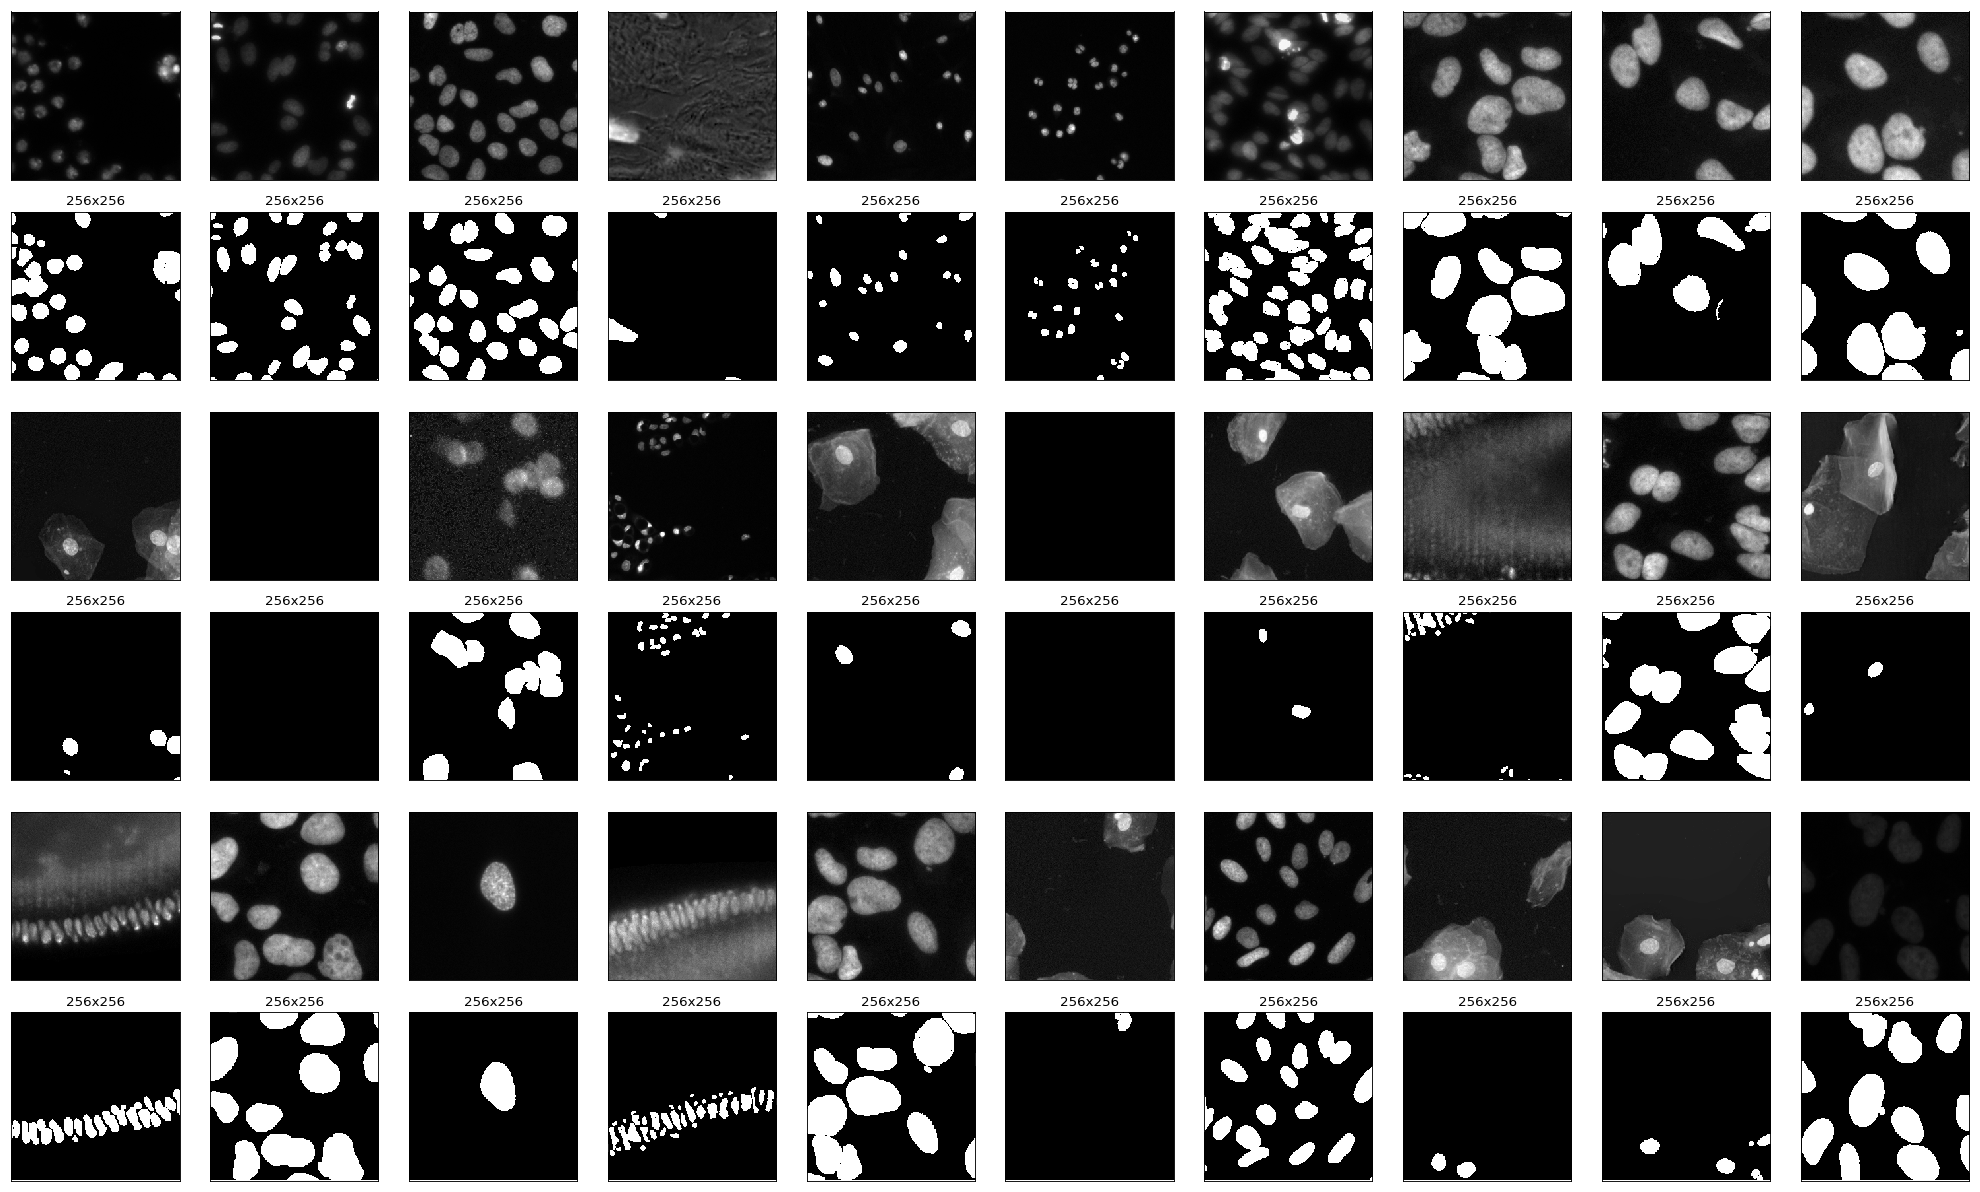

In [8]:
generator = dataset.generator(mode='training')
show_data_from_generator(generator,3, 10, (25,15))

### Show some preprocessed validation images
This section shows several images and masks from the validation set

Found 222 images belonging to 1 classes.
Found 222 images belonging to 1 classes.


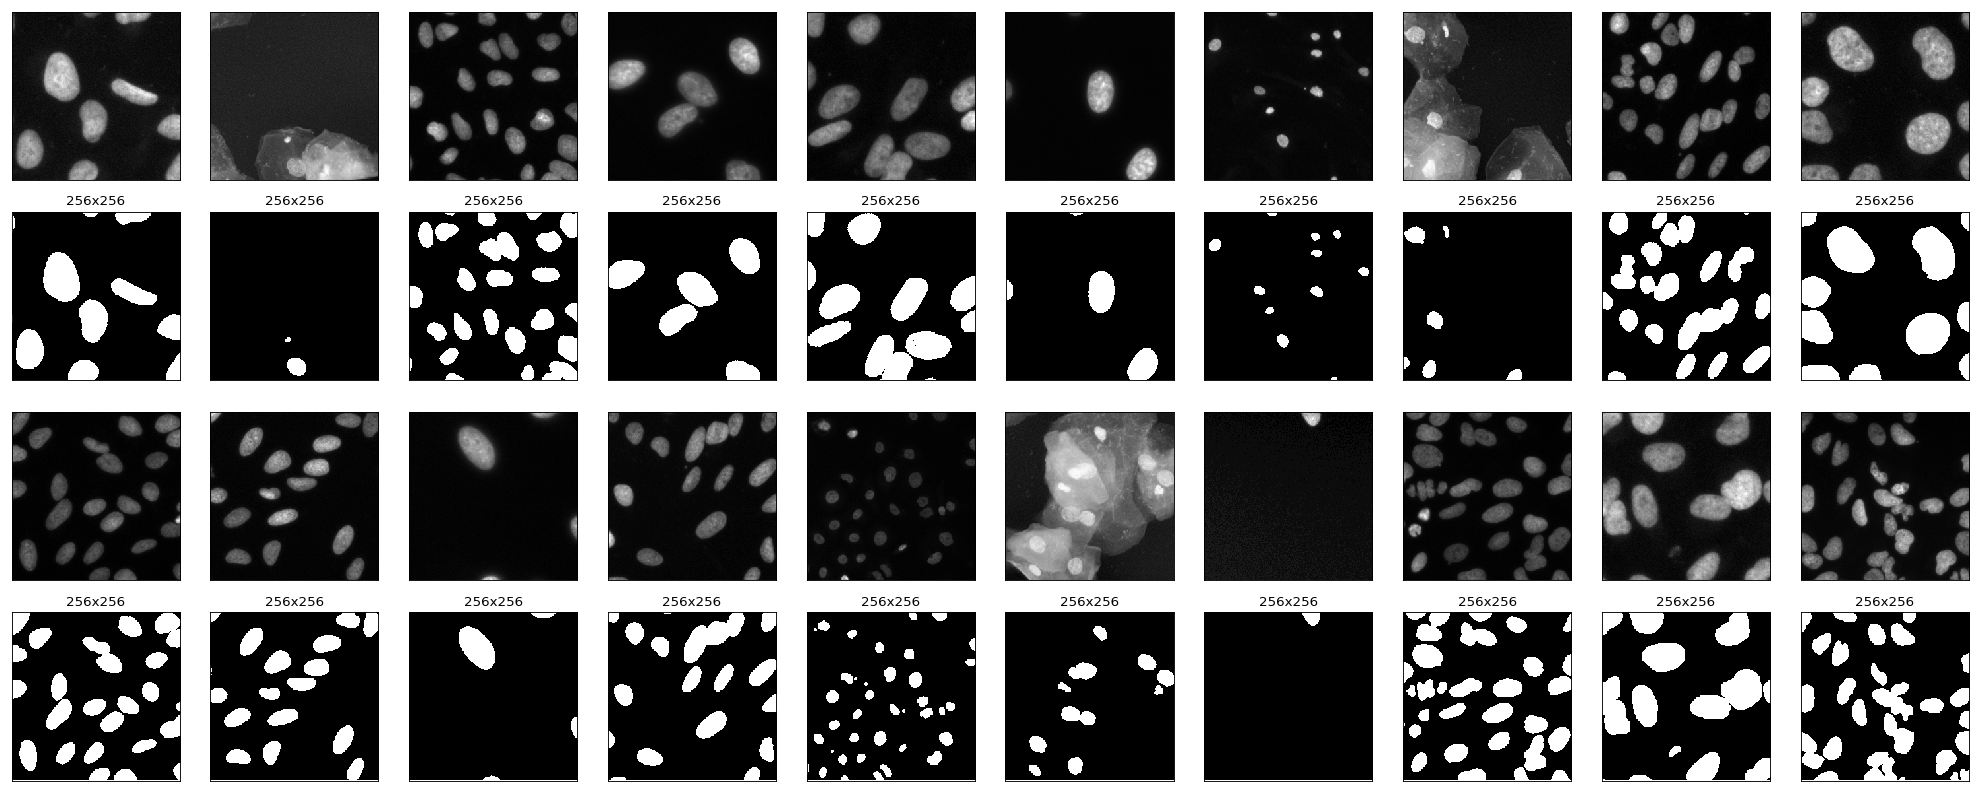

In [9]:
generator = dataset.generator(mode='validation')
show_data_from_generator(generator,2, 10, (25, 10))

### Show some testing images (not preprocessed)
This section shows test images and corresponded nucleus masks. The images are not tiled nor preprocess. Tiling, preprocessing and combining of the prediction results occurs in the inferrence process.

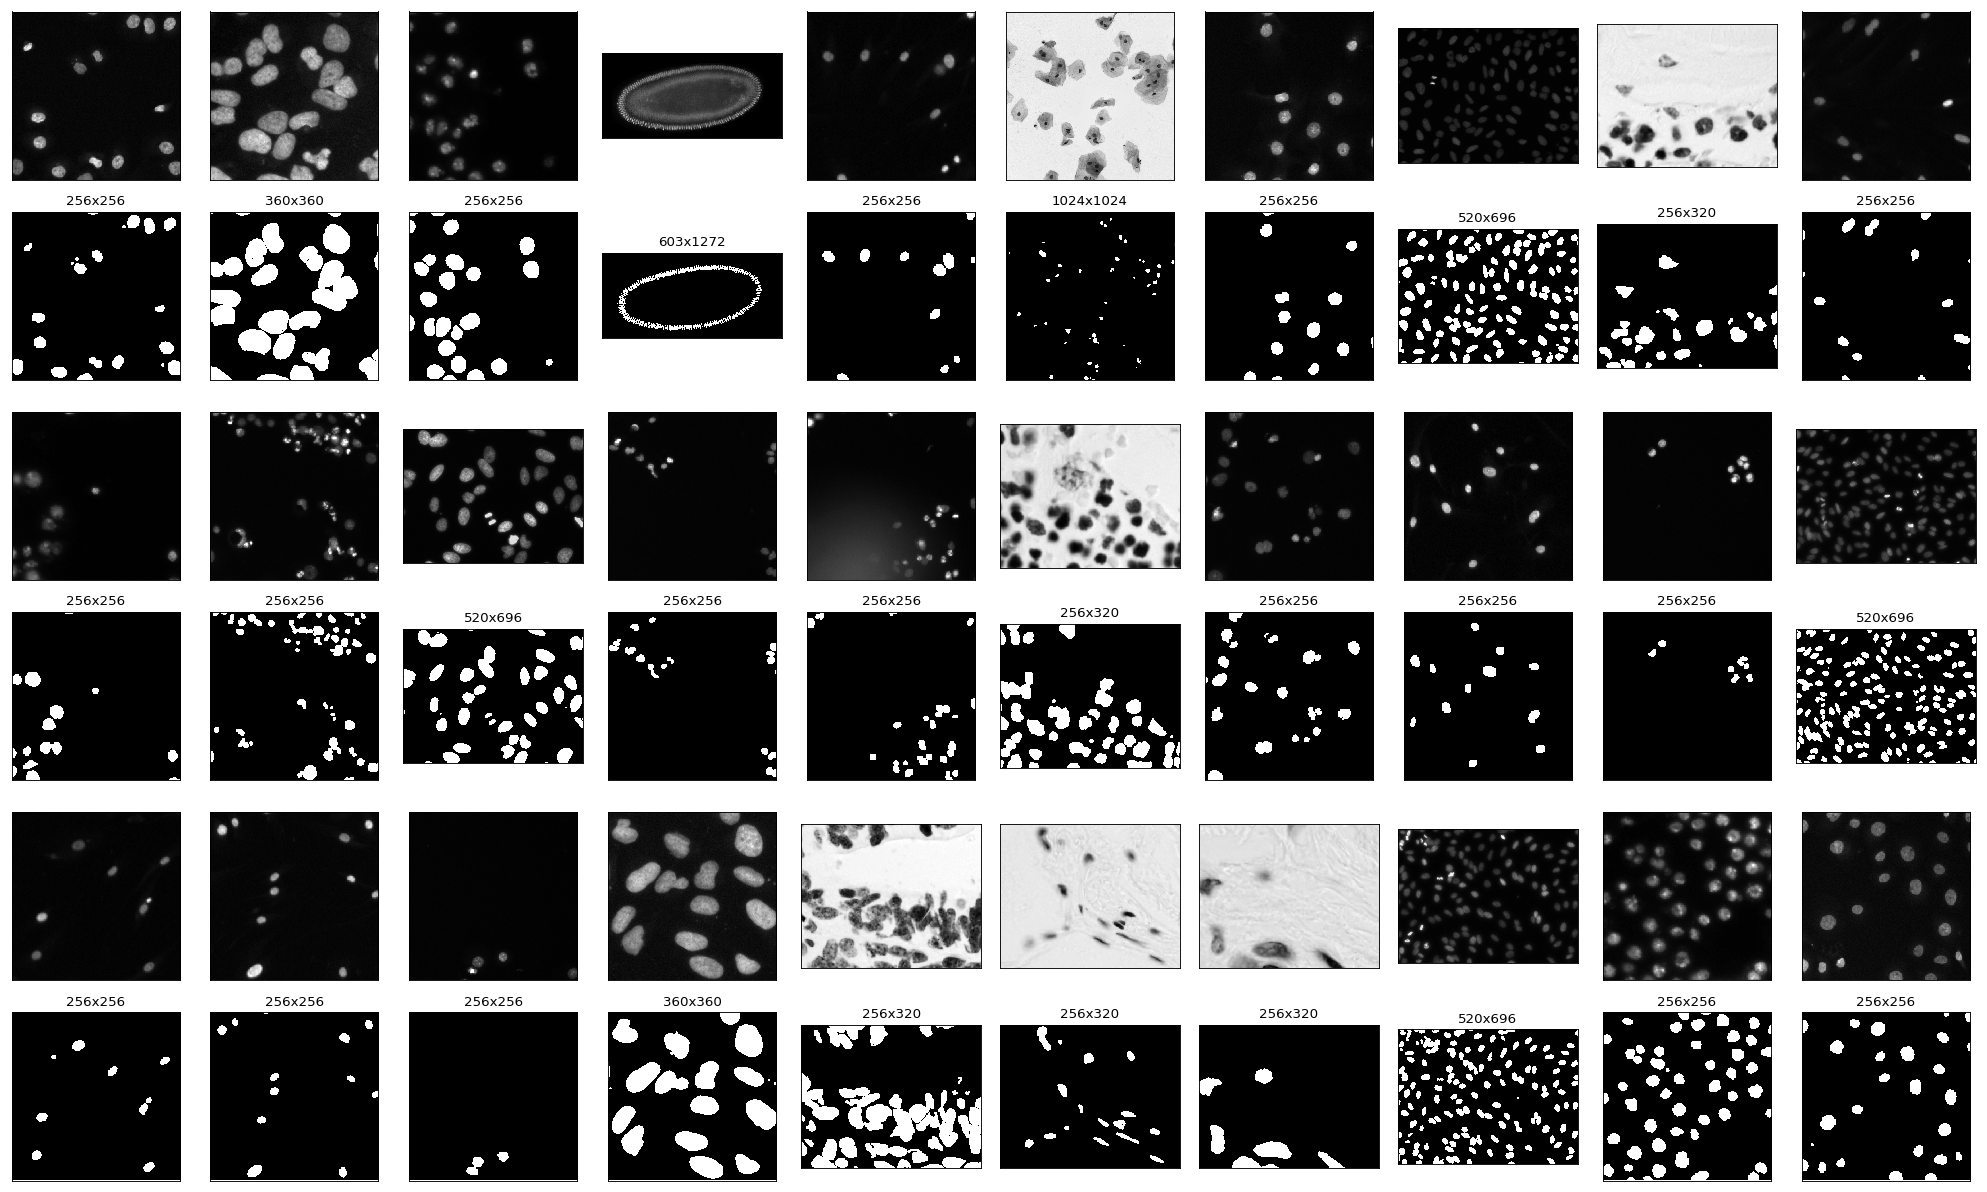

In [10]:
generator = dataset.generator(mode='test')
show_data_from_generator(generator,3, 10, (25,15))

## Setup optimizer

In [11]:
optimizer = keras.optimizers.Adam(lr = learning_rate)

## Build model

In [12]:
builder = Unet(input_shape=input_shape)
model = builder.build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         input[0][0]                      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

## Dataset generators

In [13]:
train_generator = dataset.generator('training', batch_size=batch_size)
valid_generator = dataset.generator('validation', batch_size=10)

## Metrics

In [14]:
def pixel_difference(y_true, y_pred):
    '''
    Custom metrics for comparison of images
    pixel by pixel. 
    '''
    cof = 100/(input_shape[0]*input_shape[1]*batch_size)
    return cof*K.sum(K.abs(y_true - y_pred))

metrics = ['accuracy', pixel_difference]

## Compile model

In [15]:
model.compile(optimizer=optimizer, loss = loss, metrics = metrics)

## Callbacks

In [16]:
# tensor board
tensorboard = keras.callbacks.TensorBoard(log_dir=tensor_board_directory, histogram_freq=0, write_graph=True, write_images=True, update_freq=100)
# image prediction history to be shown in the Tensor board
v_generator = dataset.generator('validation', batch_size=1)
v_data = [next(v_generator) for item in range(5)]
image_history = ImageHistory(tensor_board_dir=tensor_board_directory, data=v_data, last_step=last_step, draw_interval=100)
# model saving at end of an epoch
model_checkpoint = keras.callbacks.ModelCheckpoint(weight_file, monitor='loss',verbose=1, save_best_only=True)

Found 222 images belonging to 1 classes.
Found 222 images belonging to 1 classes.


## Load weights from previous steps

In [17]:
if os.path.isfile(weight_file):
    print('load weights')
    model.load_weights(weight_file)

load weights


## Train Model

In [18]:
model.fit_generator(generator=train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, initial_epoch=start_epoch,
                    validation_data=valid_generator, validation_steps=30,
                    callbacks=[model_checkpoint, tensorboard, image_history])

Epoch 3/3
Found 222 images belonging to 1 classes.
Found 1962 images belonging to 1 classes.
Found 222 images belonging to 1 classes.
Found 1962 images belonging to 1 classes.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


4000/4000 [==============================] - 11283s 3s/step - loss: 0.0060 - acc: 0.9975 - pixel_difference: 0.3570 - val_loss: 0.1466 - val_acc: 0.9796 - val_pixel_difference: 1.0278

Epoch 00003: loss improved from inf to 0.00605, saving model to ./unet_dsb_weights.hdf5


Picture below shows evolution of the prediction masks generated during the training on different steps. The last row shows manual annotation
![](images/dsb-masks.png)

## Explore results
Some functions for the explorations

In [23]:
def generate_segmentation_mask(model, dataset, image):
    '''
    Function generates segmentation mask for given image.
    Image willbe tiled. Tiles will be processed with the
    given model. Resulting tile masks will be combined
    in resulting mask.
    Parameters:
        model: trained keras model
        dataset: instance of DataScienceBowl2018 class
        image: numpy array that represent image to be segmented
    Return value: numpy array wit segmentation mask
    '''
    mean = np.mean(image)
    if mean>80:
        image = (255 - image)
    image_tiles = dataset.split_image_to_tiles(image)
    tile_num = len(image_tiles)
    tile_shape = image_tiles[0].shape
    batch = np.zeros((tile_num, tile_shape[0], tile_shape[1], 1))
    for tile_index in range(tile_num):
        tile = image_tiles[tile_index]
        tile = Dataset.normalize_image(tile)
        batch[tile_index,:,:,0] = tile
    mask_batch = model.predict(batch)
    mask_tiles = []
    for tile_index in range(tile_num):
        tile = mask_batch[tile_index,:,:,0]
        mask_tiles.append(tile)
    mask = dataset.combine_image_from_tiles(image.shape, mask_tiles)
    return mask

In [20]:
def show_test_prediction(number_of_test_images, error_threshold, show_diff=False):
    '''
    Function shows images from the test set. For each image will be shown as well
    annotated segmentation mask, generated segmentation mask and difference between
    annotation and prediction.
    Parameters: 
        number_of_test_images: number of test images to be shown
        error_threshold: show images only with error bigger as the threshold
        show_diff: if True, difference between prediction and annotation will be shown
    '''
    t_generator = dataset.generator('test', batch_size=1)

    cols = 10
    rows = (number_of_test_images-1)//cols + 1
    if cols > number_of_test_images:
        cols = number_of_test_images
        
    subrows = 3
    if show_diff:
        subrows = 4

    plt.figure(figsize=(5*cols, 15*rows))
    item = 0
    for image, label in t_generator:
        mask = generate_segmentation_mask(model, dataset, image)
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        label1 = Dataset.normalize_label(label)
        pixel_dif = np.sum(np.abs(mask - label1))/(image.shape[0]*image.shape[1]/100)
        if pixel_dif>=error_threshold:
            row = item//cols
            col = item%cols
            plt.subplot2grid((rows*subrows,cols),(row*subrows, col))
            plt.xticks([])
            plt.yticks([])
            plt.title('error=' + str(pixel_dif))
            plt.imshow(image,cmap='gray')
            plt.subplot2grid((rows*subrows,cols),(row*subrows+1, col))
            plt.xticks([])
            plt.yticks([])
            plt.imshow(label1,cmap='gray')
            plt.subplot2grid((rows*subrows,cols),(row*subrows+2, col))
            plt.xticks([])
            plt.yticks([])
            plt.imshow(mask,cmap='gray')
            if show_diff:
                plt.subplot2grid((rows*subrows,cols),(row*subrows+3, col))
                plt.xticks([])
                plt.yticks([])
                diff = np.abs(label1 - mask)
                plt.imshow(diff,cmap='gray')
            item += 1
        if item>=number_of_test_images:
            break
    plt.show()
    

In [11]:
def compute_test_errors(number_of_test_images):
    '''
    Function iterates through the test set, generates prediction mask
    and computes pixel difference the between prediction and corresponded
    annotation
    Parameters:
        number_of_test_images: how many of test images have to be processed
    Return value: list or pixel differences per image
    '''
    t_generator = dataset.generator('test', batch_size=1)
    item = 0
    diffs = []
    for image, label in t_generator:
        mask = generate_segmentation_mask(model, dataset, image)
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        label1 = Dataset.normalize_label(label)
        pixel_dif = np.sum(np.abs(mask - label1))/(image.shape[0]*image.shape[1]/100)
        diffs.append(pixel_dif)
    return diffs

### Compute pixel differences between prediction and annotation

In [13]:
errors = compute_test_errors(67)

Error distribution density

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


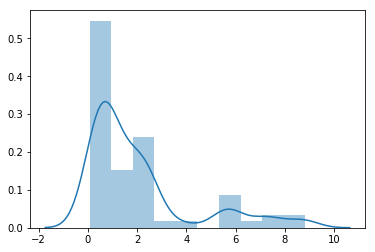

In [16]:
sns.distplot(errors)

### Generate segmentation masks

Show first 30 images from the training set

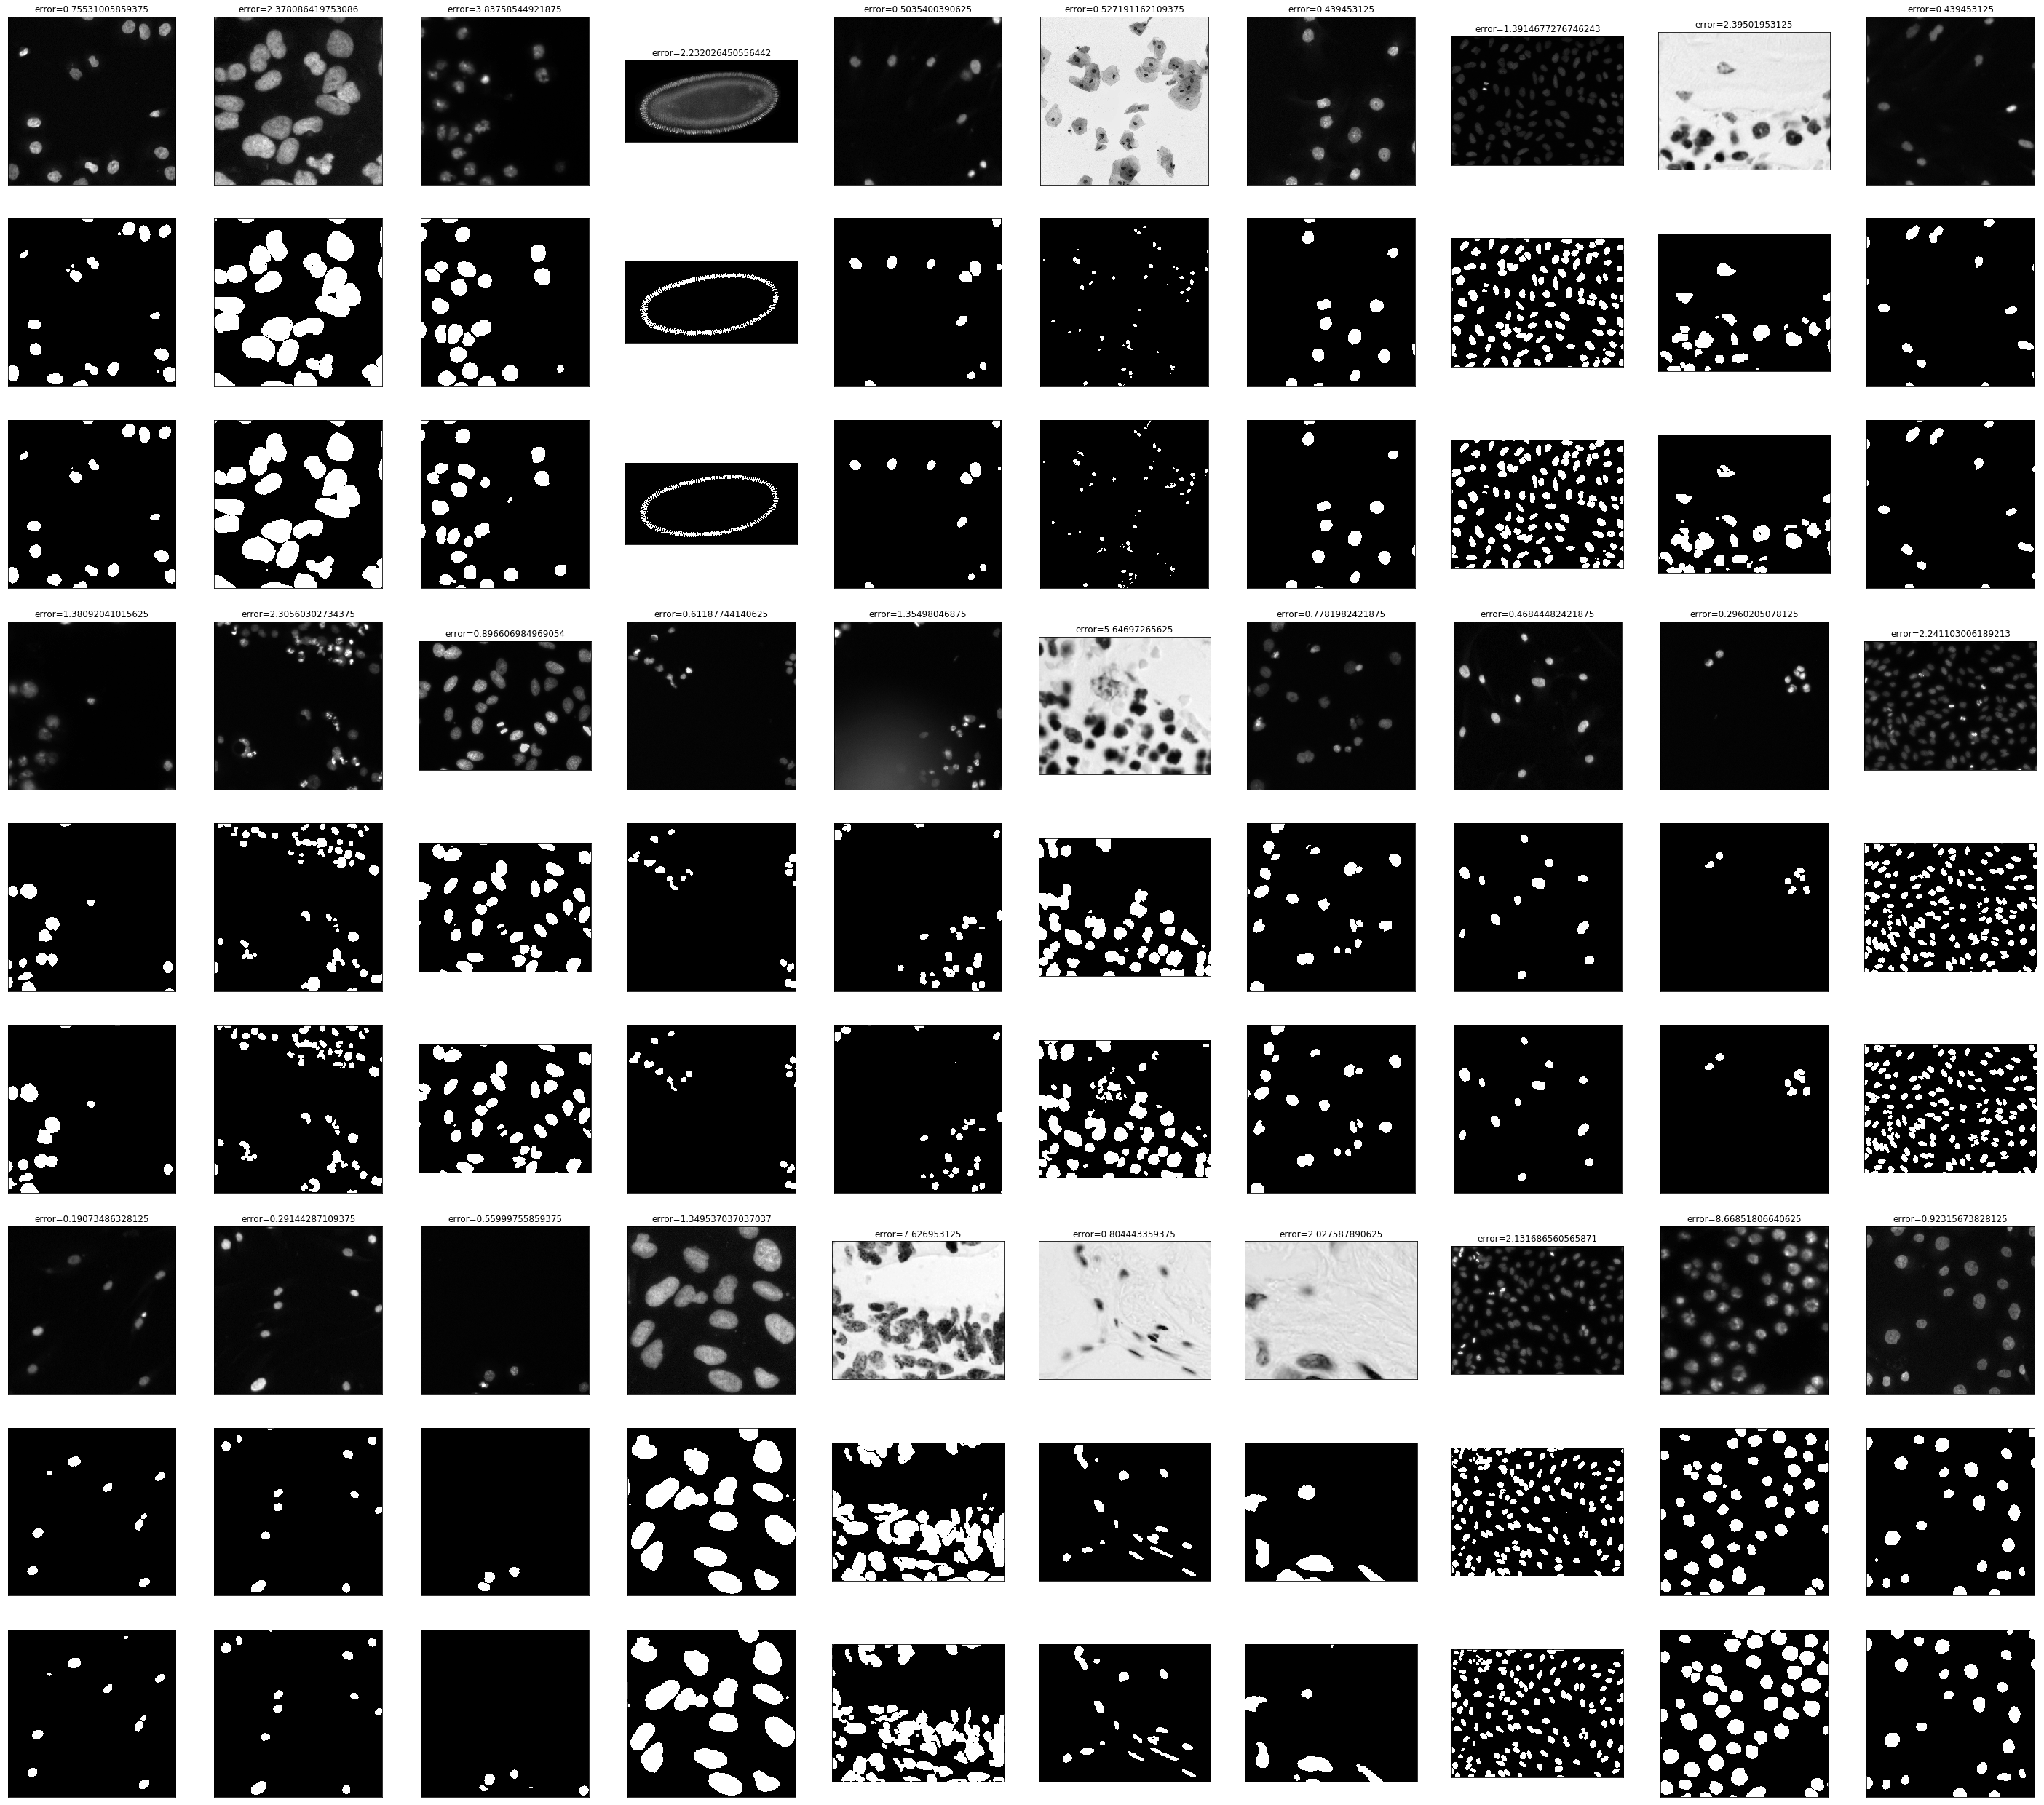

In [25]:
show_test_prediction(30, 0)

### Show images with pixel error more than 6%
Picture below shows images with the largest pixel difference between annotation and predicted mask. First row contains images, second - annotations, third - generated masks and fourth - pixel difference between manual and predicted segmentations.
Despite of relatively large amount of pixel different in annotation and predicted mask, quality of the generated segmentation is not so bad. Most difference appear on diffuse nucleus border and on overlapping nuclei. Nevertheless all nuclei were detected.

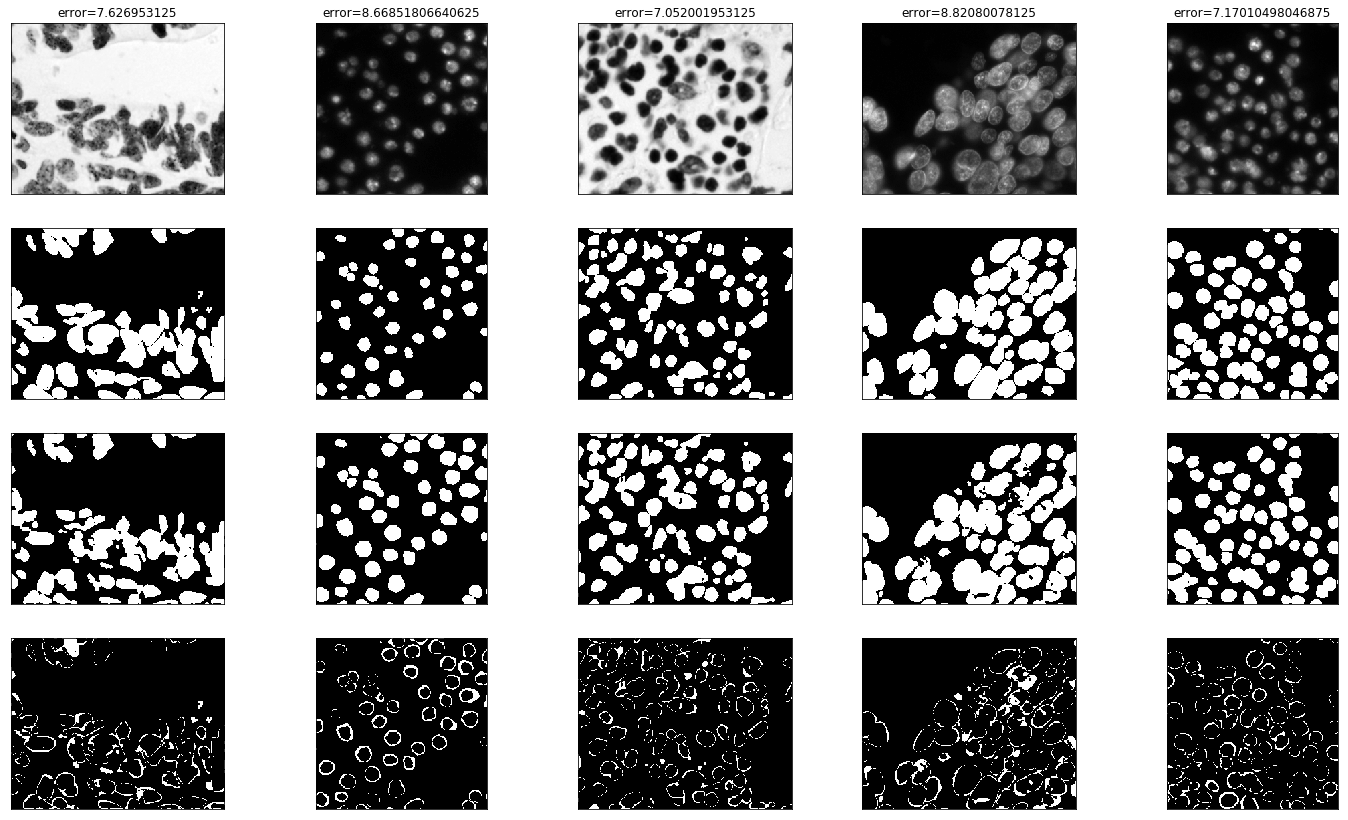

In [23]:
show_test_prediction(67, 6, True)